In [96]:
import pandas as pd
import os
import numpy as np
import torch
os.chdir('/home/tm_ba/Desktop/Bachelorarbeit_code')

In [97]:
df = pd.read_csv("csv_new/processed_Trajectories.csv")
df

,Frame,shoulder:X,shoulder:Y,shoulder:Z,elbow:X,elbow:Y,elbow:Z,wrist:X,wrist:Y,wrist:Z,ThumbTip:X,ThumbTip:Y,ThumbTip:Z,Sequence
0,1,424.563679,31.445054,632.763792,437.255669,95.056137,303.741040,326.800612,202.974780,98.728533,208.189711,226.987415,58.566404,0
1,2,424.295767,31.463165,632.810122,436.349315,95.551888,303.887265,324.416997,203.830784,100.116664,205.696950,226.350274,58.793938,0
2,3,424.058731,31.496611,632.856757,435.518783,96.208076,304.060796,321.978571,204.765964,101.315481,203.130669,225.790438,59.283324,0
3,4,423.839756,31.552288,632.884049,434.717062,96.974342,304.236887,319.504761,205.752253,102.392088,200.513515,225.286090,59.932349,0
4,5,423.629020,31.633001,632.880829,433.908156,97.811531,304.399760,317.010496,206.768091,103.398043,197.863597,224.820703,60.664590,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,484,472.782152,-7.326663,652.304919,554.735266,35.535836,329.040196,590.844187,176.464542,116.238829,553.073971,289.401170,36.425621,50
29036,485,472.813012,-7.347910,652.219975,554.945255,35.411012,329.175350,590.967573,176.501475,116.288354,553.156923,289.500379,36.527046,50
29037,486,472.858911,-7.366043,652.136989,555.194957,35.239731,329.331766,591.064473,176.525363,116.325138,553.182233,289.565935,36.574016,50
29038,487,472.932878,-7.370025,652.068414,555.489116,35.005111,329.494524,591.102419,176.537474,116.327354,553.125872,289.599658,36.607418,50


In [98]:
df.value_counts("Sequence")

Sequence
18    994
14    805
28    767
31    762
48    758
37    666
2     663
9     661
25    651
11    640
6     638
7     635
44    634
33    632
38    632
1     612
39    612
34    611
26    605
5     602
36    585
46    583
47    582
21    575
35    565
43    560
41    558
15    548
27    545
32    545
13    544
24    534
22    526
8     523
3     522
49    494
50    488
0     475
12    474
29    471
42    464
19    457
30    452
17    447
4     446
10    437
20    435
16    434
40    403
23    398
45    390
Name: count, dtype: int64

In [99]:
# Joints of interest
joints = ['shoulder', 'elbow', 'wrist', 'ThumbTip']
coordinates = ['X', 'Y', 'Z']

# Convert 'mm' to 'm' (if needed, since robot arms often use meters)
df[[f'{joint}:{coord}' for joint in joints for coord in coordinates]]

# Calculate velocity (difference in position between frames)
def calculate_velocity(df, joints, coordinates):
    velocity_df = pd.DataFrame()
    for joint in joints:
        for coord in coordinates:
            position_col = f'{joint}:{coord}'
            velocity_col = f'{joint}:{coord}_velocity'
            velocity_df[velocity_col] = df.groupby('Sequence')[position_col].diff().fillna(0)  # Calculate difference between time steps
    velocity_df["Sequence"] = df["Sequence"]
    return velocity_df

# Calculate acceleration (difference in velocity between frames)
def calculate_acceleration(velocity_df, joints, coordinates):
    acceleration_df = pd.DataFrame()
    for joint in joints:
        for coord in coordinates:
            velocity_col = f'{joint}:{coord}_velocity'
            acceleration_col = f'{joint}:{coord}_acceleration'
            acceleration_df[acceleration_col] = velocity_df.groupby('Sequence')[velocity_col].diff().fillna(0)  # Difference between velocities
    acceleration_df["Sequence"] = df["Sequence"]
    return acceleration_df

# Calculate velocity and acceleration
velocity_df = calculate_velocity(df, joints, coordinates)
acceleration_df = calculate_acceleration(velocity_df, joints, coordinates)

# Merge position, velocity, and acceleration into one DataFrame
full_data = pd.concat([df, velocity_df, acceleration_df], axis=1).drop(columns=["Sequence"])
full_data["Sequence"] = df["Sequence"]

# Organize by sequence: Create sequences for the model
sequences = full_data.groupby('Sequence').apply(lambda group: group.drop(columns=['Frame', 'Sequence']).values).values

# Example: Sequences of joint positions, velocity, and acceleration for input
X = []
Y = []

# Prepare the data: Input (X) will be current positions, velocities, accelerations
# Output (Y) will be the next time step's positions

for seq in sequences:
    # Each sequence is a separate time-series for one movement
    for i in range(len(seq) - 1):  # We stop at len(seq)-1 to predict the next time step
        X.append(seq[i])  # Input: current time step (positions, velocity, acceleration)
        Y.append(seq[i+1][:len(joints)*3])  # Output: next time step's positions (x, y, z)

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

# X shape: (num_samples, num_features) -- for LSTMs, should reshape to (num_samples, timesteps, num_features)
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print(f"X range: {X.min()} to {X.max()}",)
print(f"Y range: {Y.min()} to {Y.max()}",)

X shape: (28989, 36)
Y shape: (28989, 12)
X range: -116.11421904587536 to 664.1008282134771
Y range: -116.11421904587536 to 664.1008282134771


/tmp/ipykernel_235575/3481108350.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sequences = full_data.groupby('Sequence').apply(lambda group: group.drop(columns=['Frame', 'Sequence']).values).values


In [100]:
full_data.value_counts("Sequence")

Sequence
18    994
14    805
28    767
31    762
48    758
37    666
2     663
9     661
25    651
11    640
6     638
7     635
44    634
33    632
38    632
1     612
39    612
34    611
26    605
5     602
36    585
46    583
47    582
21    575
35    565
43    560
41    558
15    548
27    545
32    545
13    544
24    534
22    526
8     523
3     522
49    494
50    488
0     475
12    474
29    471
42    464
19    457
30    452
17    447
4     446
10    437
20    435
16    434
40    403
23    398
45    390
Name: count, dtype: int64

In [101]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Group data by sequence
grouped = full_data.groupby('Sequence')

# Prepare input (X) and output (Y) for each sequence individually
X_seqs = []
Y_seqs = []
lengths = []  # To store original sequence lengths

for _, group in grouped:
    X_seq = torch.tensor(group.drop(columns=['Frame', 'Sequence']).values[:-1], dtype=torch.float32)  # Input sequence (positions, velocities, accelerations)
    Y_seq = torch.tensor(group[['shoulder:X', 'shoulder:Y', 'shoulder:Z',  # Output sequence (next positions)
                   'elbow:X', 'elbow:Y', 'elbow:Z',
                   'wrist:X', 'wrist:Y', 'wrist:Z',
                   'ThumbTip:X', 'ThumbTip:Y', 'ThumbTip:Z']].values[1:], dtype=torch.float32)  # Next positions
    
    # Only add non-empty sequences
    if len(X_seq) > 0 and len(Y_seq) > 0:
        X_seqs.append(X_seq)
        Y_seqs.append(Y_seq)
        # Store original length before padding
        lengths.append(len(X_seq))



# Pad sequences to the same length using PyTorch pad_sequence
X_padded = pad_sequence(X_seqs, batch_first=True, padding_value=0.0)
Y_padded = pad_sequence(Y_seqs, batch_first=True, padding_value=0.0)

# Convert original lengths to PyTorch tensor
lengths_tensor = torch.tensor(lengths)

# X_padded and Y_padded are now properly grouped by sequence, with padding if necessary
print("X_padded shape:", X_padded.shape)
print("Y_padded shape:", Y_padded.shape)
print("Lengths shape:", lengths_tensor.shape)


X_padded shape: torch.Size([51, 993, 36])
Y_padded shape: torch.Size([51, 993, 12])
Lengths shape: torch.Size([51])


### Step 1: Data Normalization

In [102]:
from Code.preprocessing.Model import MotionModel, AttentionLayer


In [103]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class MotionDataset(Dataset):
    def __init__(self, X, Y, X_mean=None, X_std=None, Y_mean=None, Y_std=None):
        self.X = X
        self.Y = Y
        self.X_mean = X_mean
        self.X_std = X_std
        self.Y_mean = Y_mean
        self.Y_std = Y_std

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        X_item = self.X[idx]
        Y_item = self.Y[idx]
        
        # Apply normalization if mean and std are provided
        if self.X_mean is not None and self.X_std is not None:
            X_item = (X_item - self.X_mean) / self.X_std
        if self.Y_mean is not None and self.Y_std is not None:
            Y_item = (Y_item - self.Y_mean) / self.Y_std
        
        return X_item, Y_item


In [104]:
import torch
from torch.utils.data import DataLoader, random_split

# Convert data to PyTorch tensors
X = torch.tensor(X_padded, dtype=torch.float32)
Y = torch.tensor(Y_padded, dtype=torch.float32)

# Split data into training, validation, and test sets
dataset_size = X.shape[0]
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Create the dataset (your MotionDataset should take X and Y as arguments)
full_dataset = MotionDataset(X, Y)

# Split the lengths tensor in the same way as the dataset
lengths_tensor = torch.tensor(lengths, dtype=torch.long)

# Calculate the indices for splitting
train_idx = range(0, train_size)
val_idx = range(train_size, train_size + val_size)
test_idx = range(train_size + val_size, dataset_size)

# Split the lengths tensor using the same indices
lengths_train = lengths_tensor[train_idx]
lengths_val = lengths_tensor[val_idx]
lengths_test = lengths_tensor[test_idx]

# Split the dataset using the same proportions
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Compute mean and std from ONLY the training data
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=len(dataset))
    X_batch, Y_batch = next(iter(loader))
    X_flat = X_batch.view(-1, X_batch.shape[-1])  # Flatten the data along all but the last dimension
    Y_flat = Y_batch.view(-1, Y_batch.shape[-1])  # Flatten labels in the same way
    X_mean = X_flat.mean(dim=0)
    X_std = X_flat.std(dim=0)
    Y_mean = Y_flat.mean(dim=0)
    Y_std = Y_flat.std(dim=0)
    # Avoid division by zero for any constant feature
    X_std[X_std == 0] = 1
    Y_std[Y_std == 0] = 1
    return X_mean, X_std, Y_mean, Y_std

# Compute mean and std from the training set
X_mean, X_std, Y_mean, Y_std = compute_mean_std(train_dataset)

# Now create a normalized dataset by passing the computed mean and std
class NormalizedMotionDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, X_mean, X_std, Y_mean, Y_std):
        self.X = (X - X_mean) / X_std
        self.Y = (Y - Y_mean) / Y_std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Normalize each split using the mean and std from the training set
train_X, train_Y = zip(*[(X, Y) for X, Y in train_dataset])
val_X, val_Y = zip(*[(X, Y) for X, Y in val_dataset])
test_X, test_Y = zip(*[(X, Y) for X, Y in test_dataset])

train_X = torch.stack(train_X)
train_Y = torch.stack(train_Y)
val_X = torch.stack(val_X)
val_Y = torch.stack(val_Y)
test_X = torch.stack(test_X)
test_Y = torch.stack(test_Y)

# Create normalized datasets
train_dataset = NormalizedMotionDataset(train_X, train_Y, X_mean, X_std, Y_mean, Y_std)
val_dataset = NormalizedMotionDataset(val_X, val_Y, X_mean, X_std, Y_mean, Y_std)
test_dataset = NormalizedMotionDataset(test_X, test_Y, X_mean, X_std, Y_mean, Y_std)

# Now you have normalized datasets for training, validation, and testing
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")


Train dataset length: 40
Validation dataset length: 5
Test dataset length: 6


/tmp/ipykernel_235575/1492581289.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_padded, dtype=torch.float32)
/tmp/ipykernel_235575/1492581289.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_padded, dtype=torch.float32)


### Step 2: Model Implementation

In [105]:
import torch.nn as nn
import torch.nn.functional as F


### Step 3: Custom Loss Function

In [106]:
def custom_loss(y_pred, y_true, mask):
    # mask: [batch_size, seq_len]
    mask = mask.unsqueeze(-1)  # [batch_size, seq_len, 1]
    mask = mask.float()
    
    # Position loss
    position_loss = ((y_true - y_pred) ** 2) * mask
    position_loss = position_loss.sum() / mask.sum()
    
    # Compute velocities
    def compute_velocity(y):
        y_shifted = torch.zeros_like(y)
        y_shifted[:, 1:, :] = y[:, :-1, :]
        velocity = (y - y_shifted) * mask
        return velocity
    
    # Compute accelerations
    def compute_acceleration(v):
        v_shifted = torch.zeros_like(v)
        v_shifted[:, 1:, :] = v[:, :-1, :]
        acceleration = (v - v_shifted) * mask
        return acceleration
    
    # Predicted velocities and accelerations
    pred_velocity = compute_velocity(y_pred)
    pred_acceleration = compute_acceleration(pred_velocity)
    
    # True velocities and accelerations
    true_velocity = compute_velocity(y_true)
    true_acceleration = compute_acceleration(true_velocity)
    
    # Velocity loss
    velocity_loss = ((true_velocity - pred_velocity) ** 2) * mask
    velocity_loss = velocity_loss.sum() / mask.sum()
    
    # Acceleration loss
    acceleration_loss = ((true_acceleration - pred_acceleration) ** 2) * mask
    acceleration_loss = acceleration_loss.sum() / mask.sum()
    
    # Total loss with weighting
    total_loss = (
        position_loss
        + 0.1 * velocity_loss
        + 0.01 * acceleration_loss
    )
    return total_loss


### Step 4: Model Training

In [107]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # batch is a list of tuples (X_item, Y_item)
    X_batch, Y_batch = zip(*batch)
    lengths = [x.size(0) for x in X_batch]
    # Pad sequences
    X_padded = pad_sequence(X_batch, batch_first=True, padding_value=0.0)
    Y_padded = pad_sequence(Y_batch, batch_first=True, padding_value=0.0)
    lengths = torch.tensor(lengths)
    return X_padded, Y_padded, lengths

batch_size = 16

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)


In [108]:
input_dim = X.shape[2]
hidden_dim = 128
output_dim = Y.shape[2]
num_layers = 2

# Initialize the model
model = MotionModel(input_dim, hidden_dim, output_dim, num_layers)

# Use DataParallel for multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using 2 GPUs


In [109]:
print(input_dim, hidden_dim, output_dim, num_layers)

36 128 12 2


In [110]:
from tqdm import tqdm

num_epochs = 100
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, Y_batch, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        lengths = lengths.to(device)  # Original lengths, not padded lengths
        
        optimizer.zero_grad()
        outputs, mask = model(X_batch, lengths)  # Pass correct lengths for masking
        
        loss = custom_loss(outputs, Y_batch, mask)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch, lengths in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            lengths = lengths.to(device)  # Original lengths, not padded lengths
            
            outputs, mask = model(X_batch, lengths)  # Pass correct lengths for masking
            
            loss = custom_loss(outputs, Y_batch, mask)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_dataset)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the model
        torch.save(X_mean, 'X_mean.pth')
        torch.save(X_std, 'X_std.pth')
        torch.save(Y_mean, 'Y_mean.pth')
        torch.save(Y_std, 'Y_std.pth')

        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break


Epoch 1/100: 100%|██████████| 3/3 [00:00<00:00,  9.67it/s]


Epoch 1, Train Loss: 11.725180, Val Loss: 9.161070


Epoch 2/100: 100%|██████████| 3/3 [00:00<00:00, 11.00it/s]


Epoch 2, Train Loss: 10.110530, Val Loss: 6.268955


Epoch 3/100: 100%|██████████| 3/3 [00:00<00:00, 11.92it/s]


Epoch 3, Train Loss: 6.552099, Val Loss: 2.266303


Epoch 4/100: 100%|██████████| 3/3 [00:00<00:00, 11.38it/s]


Epoch 4, Train Loss: 4.273350, Val Loss: 3.205917


Epoch 5/100: 100%|██████████| 3/3 [00:00<00:00, 11.52it/s]


Epoch 5, Train Loss: 4.761850, Val Loss: 1.468437


Epoch 6/100: 100%|██████████| 3/3 [00:00<00:00, 11.78it/s]


Epoch 6, Train Loss: 3.021458, Val Loss: 0.959862


Epoch 7/100: 100%|██████████| 3/3 [00:00<00:00, 11.93it/s]


Epoch 7, Train Loss: 2.403805, Val Loss: 0.748406


Epoch 8/100: 100%|██████████| 3/3 [00:00<00:00, 10.91it/s]


Epoch 8, Train Loss: 1.954975, Val Loss: 0.408145


Epoch 9/100: 100%|██████████| 3/3 [00:00<00:00, 11.16it/s]


Epoch 9, Train Loss: 1.702478, Val Loss: 0.333396


Epoch 10/100: 100%|██████████| 3/3 [00:00<00:00, 10.88it/s]


Epoch 10, Train Loss: 1.510564, Val Loss: 0.311942


Epoch 11/100: 100%|██████████| 3/3 [00:00<00:00, 11.83it/s]


Epoch 11, Train Loss: 1.292969, Val Loss: 0.321809


Epoch 12/100: 100%|██████████| 3/3 [00:00<00:00, 12.35it/s]


Epoch 12, Train Loss: 1.131787, Val Loss: 0.237314


Epoch 13/100: 100%|██████████| 3/3 [00:00<00:00, 11.33it/s]


Epoch 13, Train Loss: 1.027600, Val Loss: 0.201634


Epoch 14/100: 100%|██████████| 3/3 [00:00<00:00, 11.00it/s]


Epoch 14, Train Loss: 0.930107, Val Loss: 0.228551


Epoch 15/100: 100%|██████████| 3/3 [00:00<00:00, 11.50it/s]


Epoch 15, Train Loss: 0.837091, Val Loss: 0.158376


Epoch 16/100: 100%|██████████| 3/3 [00:00<00:00, 11.07it/s]


Epoch 16, Train Loss: 0.731476, Val Loss: 0.114129


Epoch 17/100: 100%|██████████| 3/3 [00:00<00:00, 11.58it/s]


Epoch 17, Train Loss: 0.658351, Val Loss: 0.112289


Epoch 18/100: 100%|██████████| 3/3 [00:00<00:00, 11.53it/s]


Epoch 18, Train Loss: 0.578729, Val Loss: 0.105452


Epoch 19/100: 100%|██████████| 3/3 [00:00<00:00, 11.06it/s]


Epoch 19, Train Loss: 0.514526, Val Loss: 0.096461


Epoch 20/100: 100%|██████████| 3/3 [00:00<00:00, 10.99it/s]


Epoch 20, Train Loss: 0.475606, Val Loss: 0.092704


Epoch 21/100: 100%|██████████| 3/3 [00:00<00:00, 11.55it/s]


Epoch 21, Train Loss: 0.435254, Val Loss: 0.074044


Epoch 22/100: 100%|██████████| 3/3 [00:00<00:00, 11.45it/s]


Epoch 22, Train Loss: 0.406863, Val Loss: 0.073527


Epoch 23/100: 100%|██████████| 3/3 [00:00<00:00, 11.84it/s]


Epoch 23, Train Loss: 0.381683, Val Loss: 0.064771


Epoch 24/100: 100%|██████████| 3/3 [00:00<00:00, 12.03it/s]


Epoch 24, Train Loss: 0.358530, Val Loss: 0.067475


Epoch 25/100: 100%|██████████| 3/3 [00:00<00:00,  9.60it/s]


Epoch 25, Train Loss: 0.343489, Val Loss: 0.056190


Epoch 26/100: 100%|██████████| 3/3 [00:00<00:00, 10.24it/s]


Epoch 26, Train Loss: 0.329830, Val Loss: 0.053847


Epoch 27/100: 100%|██████████| 3/3 [00:00<00:00, 12.08it/s]


Epoch 27, Train Loss: 0.316024, Val Loss: 0.048792


Epoch 28/100: 100%|██████████| 3/3 [00:00<00:00, 10.35it/s]


Epoch 28, Train Loss: 0.308247, Val Loss: 0.044436


Epoch 29/100: 100%|██████████| 3/3 [00:00<00:00, 10.43it/s]


Epoch 29, Train Loss: 0.298192, Val Loss: 0.045938


Epoch 30/100: 100%|██████████| 3/3 [00:00<00:00, 10.81it/s]


Epoch 30, Train Loss: 0.290848, Val Loss: 0.043473


Epoch 31/100: 100%|██████████| 3/3 [00:00<00:00, 10.61it/s]


Epoch 31, Train Loss: 0.277816, Val Loss: 0.042255


Epoch 32/100: 100%|██████████| 3/3 [00:00<00:00, 11.95it/s]


Epoch 32, Train Loss: 0.273403, Val Loss: 0.037289


Epoch 33/100: 100%|██████████| 3/3 [00:00<00:00, 11.58it/s]


Epoch 33, Train Loss: 0.265427, Val Loss: 0.039602


Epoch 34/100: 100%|██████████| 3/3 [00:00<00:00, 11.15it/s]


Epoch 34, Train Loss: 0.262558, Val Loss: 0.034809


Epoch 35/100: 100%|██████████| 3/3 [00:00<00:00, 10.98it/s]


Epoch 35, Train Loss: 0.251977, Val Loss: 0.035135


Epoch 36/100: 100%|██████████| 3/3 [00:00<00:00, 10.61it/s]


Epoch 36, Train Loss: 0.251574, Val Loss: 0.035059


Epoch 37/100: 100%|██████████| 3/3 [00:00<00:00, 11.15it/s]


Epoch 37, Train Loss: 0.245664, Val Loss: 0.031765


Epoch 38/100: 100%|██████████| 3/3 [00:00<00:00, 11.57it/s]


Epoch 38, Train Loss: 0.244456, Val Loss: 0.033788


Epoch 39/100: 100%|██████████| 3/3 [00:00<00:00, 11.59it/s]


Epoch 39, Train Loss: 0.238958, Val Loss: 0.029234


Epoch 40/100: 100%|██████████| 3/3 [00:00<00:00, 10.08it/s]


Epoch 40, Train Loss: 0.234402, Val Loss: 0.035806


Epoch 41/100: 100%|██████████| 3/3 [00:00<00:00, 11.49it/s]


Epoch 41, Train Loss: 0.233900, Val Loss: 0.030828


Epoch 42/100: 100%|██████████| 3/3 [00:00<00:00, 12.78it/s]


Epoch 42, Train Loss: 0.227306, Val Loss: 0.026273


Epoch 43/100: 100%|██████████| 3/3 [00:00<00:00, 15.15it/s]


Epoch 43, Train Loss: 0.226186, Val Loss: 0.026320


Epoch 44/100: 100%|██████████| 3/3 [00:00<00:00, 12.16it/s]


Epoch 44, Train Loss: 0.221489, Val Loss: 0.028983


Epoch 45/100: 100%|██████████| 3/3 [00:00<00:00, 11.94it/s]


Epoch 45, Train Loss: 0.218335, Val Loss: 0.027813


Epoch 46/100: 100%|██████████| 3/3 [00:00<00:00, 11.76it/s]


Epoch 46, Train Loss: 0.218447, Val Loss: 0.026974


Epoch 47/100: 100%|██████████| 3/3 [00:00<00:00, 11.70it/s]


Epoch 47, Train Loss: 0.218807, Val Loss: 0.026368


Epoch 48/100: 100%|██████████| 3/3 [00:00<00:00, 10.76it/s]


Epoch 48, Train Loss: 0.215693, Val Loss: 0.024727


Epoch 49/100: 100%|██████████| 3/3 [00:00<00:00, 11.72it/s]


Epoch 49, Train Loss: 0.212753, Val Loss: 0.028020


Epoch 50/100: 100%|██████████| 3/3 [00:00<00:00, 11.79it/s]


Epoch 50, Train Loss: 0.213570, Val Loss: 0.024697


Epoch 51/100: 100%|██████████| 3/3 [00:00<00:00, 11.83it/s]


Epoch 51, Train Loss: 0.207621, Val Loss: 0.027451


Epoch 52/100: 100%|██████████| 3/3 [00:00<00:00, 11.63it/s]


Epoch 52, Train Loss: 0.208619, Val Loss: 0.025160


Epoch 53/100: 100%|██████████| 3/3 [00:00<00:00, 11.47it/s]


Epoch 53, Train Loss: 0.204634, Val Loss: 0.024372


Epoch 54/100: 100%|██████████| 3/3 [00:00<00:00, 11.51it/s]


Epoch 54, Train Loss: 0.204516, Val Loss: 0.024974


Epoch 55/100: 100%|██████████| 3/3 [00:00<00:00, 11.76it/s]


Epoch 55, Train Loss: 0.200146, Val Loss: 0.024852


Epoch 56/100: 100%|██████████| 3/3 [00:00<00:00, 11.75it/s]


Epoch 56, Train Loss: 0.198280, Val Loss: 0.023629


Epoch 57/100: 100%|██████████| 3/3 [00:00<00:00, 11.71it/s]


Epoch 57, Train Loss: 0.199437, Val Loss: 0.022446


Epoch 58/100: 100%|██████████| 3/3 [00:00<00:00, 11.62it/s]


Epoch 58, Train Loss: 0.198193, Val Loss: 0.022290


Epoch 59/100: 100%|██████████| 3/3 [00:00<00:00, 10.70it/s]


Epoch 59, Train Loss: 0.198360, Val Loss: 0.024964


Epoch 60/100: 100%|██████████| 3/3 [00:00<00:00, 11.54it/s]


Epoch 60, Train Loss: 0.194708, Val Loss: 0.021406


Epoch 61/100: 100%|██████████| 3/3 [00:00<00:00, 11.90it/s]


Epoch 61, Train Loss: 0.195014, Val Loss: 0.022652


Epoch 62/100: 100%|██████████| 3/3 [00:00<00:00, 11.60it/s]


Epoch 62, Train Loss: 0.190889, Val Loss: 0.020443


Epoch 63/100: 100%|██████████| 3/3 [00:00<00:00, 11.62it/s]


Epoch 63, Train Loss: 0.194576, Val Loss: 0.020853


Epoch 64/100: 100%|██████████| 3/3 [00:00<00:00, 11.96it/s]


Epoch 64, Train Loss: 0.191856, Val Loss: 0.020408


Epoch 65/100: 100%|██████████| 3/3 [00:00<00:00, 12.08it/s]


Epoch 65, Train Loss: 0.189258, Val Loss: 0.019978


Epoch 66/100: 100%|██████████| 3/3 [00:00<00:00, 11.51it/s]


Epoch 66, Train Loss: 0.187006, Val Loss: 0.022539


Epoch 67/100: 100%|██████████| 3/3 [00:00<00:00, 11.29it/s]


Epoch 67, Train Loss: 0.189590, Val Loss: 0.022313


Epoch 68/100: 100%|██████████| 3/3 [00:00<00:00, 10.76it/s]


Epoch 68, Train Loss: 0.185941, Val Loss: 0.024629


Epoch 69/100: 100%|██████████| 3/3 [00:00<00:00, 10.80it/s]


Epoch 69, Train Loss: 0.185416, Val Loss: 0.023051


Epoch 70/100: 100%|██████████| 3/3 [00:00<00:00, 11.87it/s]


Epoch 70, Train Loss: 0.186838, Val Loss: 0.026390


Epoch 71/100: 100%|██████████| 3/3 [00:00<00:00,  9.85it/s]


Epoch 71, Train Loss: 0.186513, Val Loss: 0.023208


Epoch 72/100: 100%|██████████| 3/3 [00:00<00:00, 11.33it/s]


Epoch 72, Train Loss: 0.186360, Val Loss: 0.023572


Epoch 73/100: 100%|██████████| 3/3 [00:00<00:00, 10.61it/s]


Epoch 73, Train Loss: 0.186008, Val Loss: 0.022380


Epoch 74/100: 100%|██████████| 3/3 [00:00<00:00, 10.99it/s]


Epoch 74, Train Loss: 0.185162, Val Loss: 0.024330


Epoch 75/100: 100%|██████████| 3/3 [00:00<00:00,  9.98it/s]


Epoch 75, Train Loss: 0.186293, Val Loss: 0.021501
Early stopping


### Step 5: Evaluation and Fine-Tuning

In [111]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, Y_batch, lengths in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        lengths = lengths.to(device)
        
        outputs, mask = model(X_batch, lengths)
        
        loss = custom_loss(outputs, Y_batch, mask)
        test_loss += loss.item() * X_batch.size(0)
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.6f}")


Test Loss: 0.020737


/tmp/ipykernel_235575/2864630211.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


torch.Size([6, 993, 36])
torch.Size([1, 445, 36])


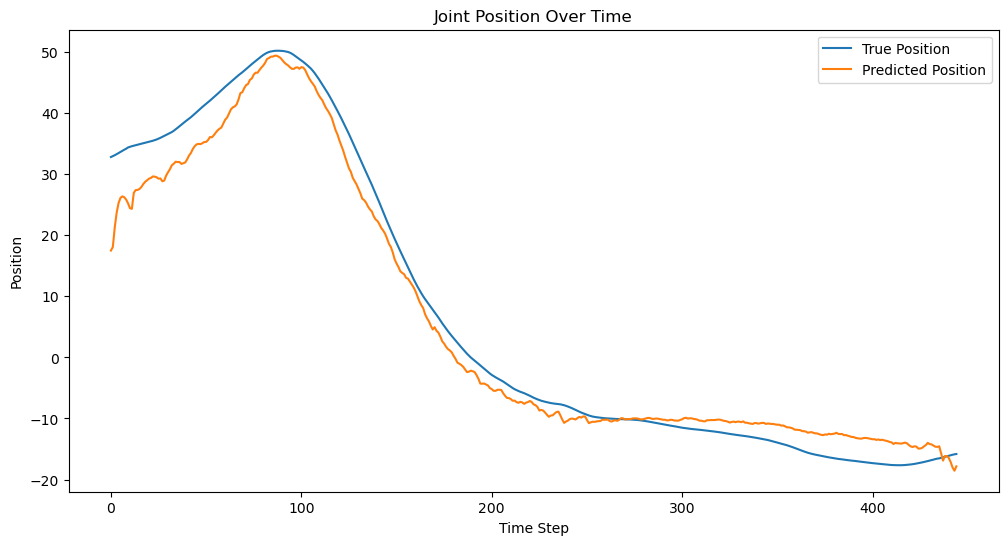

In [112]:
import random
import matplotlib.pyplot as plt

# Select a random sequence from the test set
X_sequence, Y_true_sequence, lengths = next(iter(test_loader))

# Randomly select a sequence index within the batch
sequence_idx = random.randint(0, X_sequence.size(0) - 1)  # Random index from 0 to batch size - 1
length = lengths_tensor[sequence_idx]  # Ensure the correct original length is used for this sequence
print(X_sequence.shape)

# Slice up to the true length of the sequence
X_sequence = X_sequence[sequence_idx:sequence_idx+1, :length].to(device)
Y_true_sequence = Y_true_sequence[sequence_idx:sequence_idx+1, :length].to(device)
lengths_sequence = lengths_tensor[sequence_idx:sequence_idx+1]
print(X_sequence.shape)

# Predict
model.eval()
with torch.no_grad():
    outputs, mask = model(X_sequence, lengths_sequence)  # Pass the correct sequence length for evaluation

# Denormalize the output and true values
def denormalize(data, mean, std):
    mean = mean.to(device).unsqueeze(0).unsqueeze(0)
    std = std.to(device).unsqueeze(0).unsqueeze(0)
    return data * std + mean

# Denormalize
Y_true_denorm = denormalize(Y_true_sequence, Y_mean, Y_std)
Y_pred_denorm = denormalize(outputs, Y_mean, Y_std)

# Convert to CPU and numpy arrays for plotting
Y_true_denorm = Y_true_denorm.squeeze(0).cpu().numpy()
Y_pred_denorm = Y_pred_denorm.squeeze(0).cpu().numpy()

# Plot true vs predicted positions for a specific joint and coordinate
joint_idx = 0  # First joint
coordinate_idx = 1  # X-coordinate

plt.figure(figsize=(12, 6))
plt.plot(
    Y_true_denorm[:length, joint_idx * 3 + coordinate_idx],  # Only plot non-padded values
    label='True Position',
)
plt.plot(
    Y_pred_denorm[:length, joint_idx * 3 + coordinate_idx],  # Only plot non-padded values
    label='Predicted Position',
)
plt.title('Joint Position Over Time')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.legend()
plt.show()


In [113]:
lengths_tensor[0]

tensor(474)

In [114]:
!jupyter nbconvert --to script Code/preprocessing/preprocess copy.ipynb

[NbConvertApp] WARNING | pattern 'copy.ipynb' matched no files
[NbConvertApp] Converting notebook Code/preprocessing/preprocess.ipynb to script
[NbConvertApp] Writing 17119 bytes to Code/preprocessing/preprocess.py
